Degree 1
MSE train
0.026127259854541212
MSE test
0.026700931446120124
Error: 0.17646064143751425
Bias^2: 0.17569334963293146
Var: 0.0007672918045827592
0.17646064143751425 >= 0.17569334963293146 + 0.0007672918045827592 = 0.17646064143751422
Degree 2
MSE train
0.017844565843923646
MSE test
0.019592813934231967
Error: 0.1673231459413283
Bias^2: 0.16604265414011019
Var: 0.0012804918012180695
0.1673231459413283 >= 0.16604265414011019 + 0.0012804918012180695 = 0.16732314594132824
Degree 3
MSE train
0.007386812099927217
MSE test
0.008118890343045849
Error: 0.16116494941274
Bias^2: 0.1597376399421681
Var: 0.0014273094705718834
0.16116494941274 >= 0.1597376399421681 + 0.0014273094705718834 = 0.16116494941273998
Degree 4
MSE train
0.0037928749107556093
MSE test
0.004265129985566293
Error: 0.19176030216755818
Bias^2: 0.18971297655046687
Var: 0.0020473256170913086
0.19176030216755818 >= 0.18971297655046687 + 0.0020473256170913086 = 0.19176030216755818
Degree 5
MSE train
0.001872776859692776
MSE t

<Figure size 640x480 with 0 Axes>

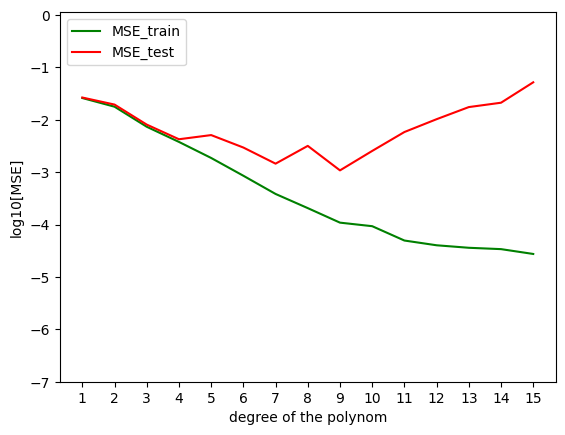

<Figure size 640x480 with 0 Axes>

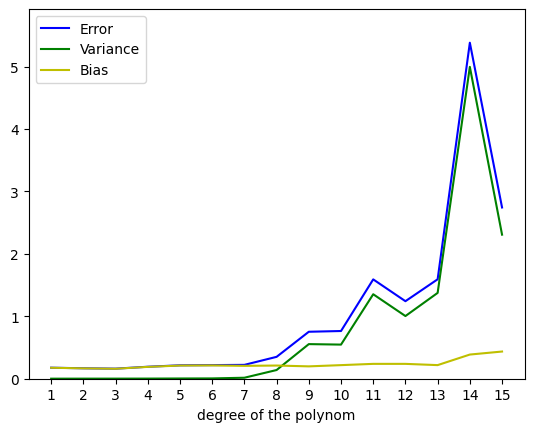

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

#Function that gives in return the value of the Mean Squared Error
def MSE(y_data,y_model):
    n = np.size(y_model)
    y_data = y_data.reshape(-1,1)
    y_model = y_model.reshape(-1,1)
    return np.sum((y_data-y_model)**2)/n

#Function that gives in return the value of the Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

#We create our data
#We reduced our amount of points by increasing the step from 0.05 to 0.1.
#We had to do this because with too many points the model is too well-trained, 
# giving us a  (almost) costant values for Bias, Error, Variance.
x = np.arange(0, 1, 0.1)
y = np.arange(0, 1, 0.1)
x, y = np.meshgrid(x,y)
#np.random.normal() adds noise to z with a normal distribution.
z = FrankeFunction(x, y) + 0.01*np.random.normal(0,1, x.shape)
n_bootstraps = 100

#Maximum degree of the polynomial
degree = 15

#Setting up the design matrix
x = x.reshape(-1,1) #reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)

#credit: M. Hjorth-Jensen: Weekly Material, Week 35
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

X = create_X(x,y,degree)

#We remove the intercept
X = X[:,1:]
# Hold out some test data that is not used in training.
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

#OLS fitting

beta_list = []
MSE_train = np.zeros(degree)
MSE_test = np.zeros(degree)
rsqr_train = np.zeros(degree)
rsqr_test = np.zeros(degree)
error = np.zeros(degree)
bias = np.zeros(degree)
variance = np.zeros(degree)

#Scaling the data, in this case we only center the data, thus we subtract the mean values from each column from every column entry
X_train_mean = np.mean(X_train,axis=0)
X_train_scaled = X_train - X_train_mean
X_test_scaled = X_test - X_train_mean
#we now calculate our model's intercept by using the expression from the lecture notes (M. Hjorth-Jensen: Notes on scaling with examples),
#which results from deriving the cost/loss function by beta0 and setting it to zero
#since our cost/loss function is convex this leads us to finding its minimum with respect to beta0
#The model intercept follows the equation z_scaler = np.mean(z_train) - np.mean(X_train_sc) * beta. Since we above centered our Designmatrix, 
#the mean vector of X_train_sc equals the zero vector. Our equation reduces to:
z_scaler = np.mean(z_train)           
z_train_scaled = z_train - z_scaler
z_test_scaled = z_test - z_scaler

#Finding the MSE for every degree.

for i in range(1, degree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = X_train_scaled[:,0:c-1]
        beta = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ z_train_scaled
		
        ypredict = (X_tilde @ beta) + z_scaler
        ypredict_test = (X_test_scaled[:,0:c-1] @ beta) + z_scaler

        MSE_train[i-1] = MSE(z_train, ypredict)
        MSE_test[i-1] = MSE(z_test, ypredict_test)

#Bootstrapping and finding Error, Bias and Variance for every degree of the polynomial.
for i in range(1,degree+1):
    c = int((i+2)*(i+1)/2)
    X_tilde = X_train_scaled[:,0:c-1]
# The following (m x n_bootstraps) matrix holds the column vectors y_pred for each bootstrap iteration.
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    for d in range(n_bootstraps):
        X_, z_ = resample(X_tilde, z_train_scaled)
        beta = np.linalg.pinv(X_.T @ X_) @ X_.T @ z_

        # Evaluate the new model on the same test data each time.
        z_pred[:,d] = (X_test_scaled[:,0:c-1] @ beta).ravel()

    # Note: Expectations and variances taken w.r.t. different training
    # data sets, hence the axis=1. Subsequent means are taken across the test data
    # set in order to obtain a total value, but before this we have error/bias/variance
    # calculated per data point in the test set.
    # Note 2: The use of keepdims=True is important in the calculation of bias as this 
    # maintains the column vector form. Dropping this yields very unexpected results.
    error[i-1] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[i-1] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i-1] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    print("Degree", i)
    print("MSE train")
    print(MSE_train[i-1])
    print("MSE test")
    print(MSE_test[i-1])
    print('Error:', error[i-1])
    print('Bias^2:', bias[i-1])
    print('Var:', variance[i-1])
    print('{} >= {} + {} = {}'.format(error[i-1], bias[i-1], variance[i-1], bias[i-1]+variance[i-1]))

# plotting the MSE  as functions of the polynomial degree
#in the graph we notice high bias & low variance (underfitting) on the left and towards the right,
#where the lines diverge, we notice low bias and high variance (overfitting).
#Bias represents the error caused by the oversimplifying of the model
#Variance represents the sensitivity of the model to small fluctuations in training data.
fig = plt.figure()

fig2, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, degree +1)
plt.xticks(xax)
ax1.set_ylim(-7, np.max(MSE_test)*1.1)
ax1.plot(xax, np.log10(MSE_train), 'g', label='MSE_train')
ax1.plot(xax, np.log10(MSE_test), 'r', label='MSE_test')
ax1.legend(loc='upper left')
ax1.set_ylabel('log10[MSE]', loc='center')

#Plotting Error, Bias, Variance over polynomial degree.
#We notice a big increase in error and bias from the 8th degree.

fig3 = plt.figure()
fig4, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, degree +1)
plt.xticks(xax)
ax1.set_ylim(0, np.max(error)*1.1)
ax1.plot(xax, error, 'b', label='Error')
ax1.plot(xax, variance, 'g', label='Variance')
ax1.plot(xax, bias, 'y', label='Bias')
ax1.legend(loc='upper left')